In [5]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [79]:
class CommNet:
    
    def __init__(self, sess, N, J, embedding_size = 128, lr = 1e-3, training_mode = 'supervised', gamma = 1):
        
        self.N = N
        self.J = J
        self.embedding_size = embedding_size
        
        self.build_controler()
        
        self.training_mode = training_mode
        
        if training_mode == 'supervised':
            self.build_supervised()
            with tf.variable_scope('Supervised_optimizer'):
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.supervised_loss)
                
        elif training_mode == 'reinforce':
            self.gamma = gamma
            self.build_reinforce()
            with tf.variable_scope('Reinforce_optimizer'):
                self.train_op =  tf.train.AdamOptimizer(lr).minimize(self.reinforce_loss)
            
        else:
            raise(ValueError("Unknown training mode: %s" % training_mode))
        
        print("All variables")
        for var in tf.global_variables():
            print(var)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        with tf.variable_scope('Encoder'):
        
            identity_embeddings = tf.get_variable("identity_embeddings",
                                             [self.N, self.embedding_size])
            
            embedded_identities = tf.nn.embedding_lookup(identity_embeddings, inputs)
            
        return tf.unstack(embedded_identities, axis = 1)
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None:
                
                W1 = tf.get_variable('W1', shape = (3 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            else:
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
            
            W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
            
            dense1 =  tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1))
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2))
            
            return dense2
        
    def decode(self, h):
        
        with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  self.J))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W)
        
            return policy_logit
    
    
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / (self.J - 1)
    
    def sample_actions(self, policy_logit):
        
        
        action = tf.multinomial(policy_logit, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, self.J))
        
        h0_seq = self.encode(self.inputs)
        c0_seq = [self.communicate([h0_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.J)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.J)]
        
        
        self.policy_logit_seq = [self.decode(h2) for h2 in h2_seq]
        
        self.action_seq = [self.sample_actions(policy_logit) for policy_logit in self.policy_logit_seq]
        
        
        
    def build_supervised(self):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        self.one_hot_action_seq = [tf.one_hot(tf.reshape(action, [-1]), depth = self.J) for action in self.action_seq]
        self.targets = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_targets = tf.unstack(self.targets, axis = 1)
        
        supervised_loss_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_targets[j],
                                                                                   logits=self.policy_logit_seq[j])
                                    for j in range(self.J)]
        
        self.supervised_loss = tf.reduce_sum(tf.add_n(supervised_loss_seq))
        
        
        
    def supervised_train(self, X, y, val_X, val_y, env, batch_size = 32, epochs = 1):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        n = X.shape[0]
        
        val_n = val_X.shape[0]
        
        data_inds = np.array(range(n))
        for ep in range(1, epochs + 1):
            np.random.shuffle(data_inds)
            supervised_loss_sum = 0
            reward_sum = 0
            for i in tqdm(range(0, n, batch_size), "Epoch: %d" % ep):
                inds_batch = data_inds[i:i+batch_size]
                X_batch = X[inds_batch]
                y_batch = y[inds_batch]
                _, supervised_loss, one_hot_action_seq = sess.run([self.train_op, self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: X_batch, self.targets: y_batch})
                supervised_loss_sum += supervised_loss
                reward_sum += env.get_reward(one_hot_action_seq)
            
            print("loss = %f" % (supervised_loss_sum / n))
            print("reward = %f" % (reward_sum / n))
            print()
            
            val_supervised_loss, val_one_hot_action_seq = sess.run([self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: val_X, self.targets: val_y})
            print('val loss = %f' % (val_supervised_loss / val_n))
            print('val reward = %f' % (env.get_reward(val_one_hot_action_seq) / val_n))
            

    def build_reinforce(self):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        self.advantage = tf.placeholder(tf.float32, shape = (None, self.J))
        unstacked_advantage = tf.unstack(self.advantage, axis = 1)
        
        self.action_taken = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_action_taken = tf.unstack(self.action_taken, axis = 1)
        
        self.neg_log_p_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_action_taken[j],
                                                    logits=self.policy_logit_seq[j]) for j in range(self.J)]
        #surrogate loss
        self.reinforce_loss =  tf.add_n([tf.reduce_mean(tf.multiply(unstacked_advantage[j], self.neg_log_p_seq[j]), axis = 0) for j in range(self.J)])
        
    def take_action(self, state):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        action_seq= self.sess.run(self.action_seq, {self.inputs: [state]})
        
        return [x[0,0] for x in action_seq]
    
    def reinforce_train(self, env, n_episodes, T):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        baseline = np.zeros(self.N)
        
        discount_factors = np.array([self.gamma ** t for t in range(T)])
        
        history = {'reward' : [],  'loss': []}
    
        
        for _ in tqdm(range(n_episodes), "REINFORCE"):
            
            # todo: change code to avoid this seq_seq name (sequence of sequence)
            state_seq, action_seq, reward_seq = policy_rollout(T, env, commNet)
            t = reward_seq.shape[0]
            G = np.sum(reward_seq * discount_factors[:t])
            
            history['reward'].append(np.mean(reward_seq))
            
            
            
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.advantage] = G * (1 - baseline[state_seq])
            feed_dict[self.action_taken] = action_seq
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
            # update baseline
            raveled_state_seq = state_seq.ravel()
            repeated_reward_seq = np.repeat(reward_seq, self.J)
            distinct_states = list(set(raveled_state_seq))
            state_count = np.zeros(self.N)
            reward_sum = np.zeros(self.N)
            
            for s,r in zip(raveled_state_seq, repeated_reward_seq):
                state_count[s] += 1
                reward_sum[s] += r
            baseline[distinct_states] = 0.99 * baseline[distinct_states] + 0.01 * reward_sum[distinct_states]/state_count[distinct_states]
        print(baseline)
        return history
            
            
            
            
            
            
            
        

In [80]:
class LeverEnv:
    
    def __init__(self, N, J):
        
        self.J = J
        self.N = N
        
    def reset(self):
        
        state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        terminal_state = False
        
        return state, terminal_state        
    
    def get_reward(self, one_hot_action_seq):        
        
        reward = np.sum(np.sum(one_hot_action_seq, axis = 0) > 0) /self.J
        
        return reward
        
    def step(self, state, action):
        
        next_state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        one_hot_action_seq = np.zeros((self.J, self.J))
        one_hot_action_seq[range(self.J), action] = 1
        reward = self.get_reward(one_hot_action_seq)
        
        terminal_state = False
        
        return next_state, reward, terminal_state
        

In [81]:
# data generation for supervised learning
def generate_data(n, N, J):
    
    X = np.empty((n, J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.sort(np.random.choice(N, size = J, replace = False))
        
    y = np.tile([j for j in range(J)], (n,1))
        
    return X, y

In [82]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    action_seq = []
    reward_seq = []
    
    
    state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        action = agent.take_action(state)
        
        state, reward, terminal_state = env.step(state, action)
        
        
        action_seq.append(action)
        reward_seq.append(reward)
        
    return np.array(state_seq), np.array(action_seq), np.array(reward_seq)

In [83]:
N = 100
J = 5
batch_size = 32
n = batch_size * 1000

In [84]:
X, y = generate_data(n, N, J)
val_X, val_y = generate_data(1024, N, J)

In [87]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNet(sess, N, J, lr = 1e-2, training_mode = 'reinforce')
    env = LeverEnv(N, J)
    #commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 10)
    
    history = commNet.reinforce_train(env, n_episodes = 3000, T = 3)

    
    state_seq, action_seq, reward_seq = policy_rollout(3, env, commNet)
    
    print(state_seq)
    print(action_seq)
    print(reward_seq)
    G = np.sum(reward_seq)
    print(G)
    
    feed_dict = {}
    feed_dict[commNet.inputs] = state_seq
    feed_dict[commNet.advantage] = G * np.ones((3, J))
    feed_dict[commNet.action_taken] = action_seq

    commNet.sess.run(commNet.train_op, feed_dict = feed_dict)
    
    rv = sess.run([commNet.policy_logit_seq, commNet.neg_log_p_seq, commNet.reinforce_loss, commNet.policy_logit_seq], feed_dict= feed_dict)
    

All variables
<tf.Variable 'Encoder/identity_embeddings:0' shape=(100, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W1:0' shape=(384, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Decoder/W:0' shape=(128, 5) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/Adam:0' shape=(100, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/Adam_1:0' shape=(100, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/Adam:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/Adam_1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Re

REINFORCE: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 97.12it/s]


[0.19799576 0.19688435 0.19706453 0.19737203 0.19723747 0.19759931
 0.19697883 0.19723546 0.19709328 0.19709328 0.19791355 0.19764881
 0.197004   0.19661998 0.19801766 0.19729502 0.19737453 0.1974748
 0.19760287 0.19655171 0.19715084 0.1968496  0.19649066 0.19648133
 0.1972648  0.19787206 0.19742327 0.19787118 0.19729216 0.1979155
 0.1971526  0.19655278 0.19739724 0.1978499  0.19715902 0.19794125
 0.19759906 0.19842629 0.19769295 0.19691261 0.19678564 0.19765982
 0.19795507 0.19762633 0.1968181  0.1971802  0.19757406 0.19771913
 0.19811324 0.19662033 0.19782818 0.19754955 0.19799597 0.1968181
 0.19726338 0.19688937 0.1967709  0.19789378 0.19771816 0.19715084
 0.19735375 0.19641249 0.19626377 0.19720754 0.1972452  0.19731784
 0.1974493  0.19726311 0.19767061 0.19767257 0.19785124 0.19672275
 0.19737258 0.19678596 0.19742622 0.19747454 0.19771768 0.19752764
 0.19799722 0.19744982 0.19648352 0.19745387 0.19764635 0.19712206
 0.19739913 0.19744904 0.19607041 0.19723546 0.19691584 0.1963797

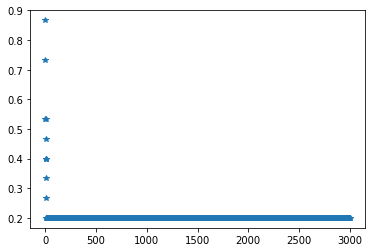

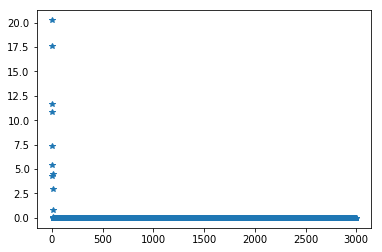

In [88]:
plt.plot(history['reward'], '*')
plt.show()
plt.plot(history['loss'], '*')
plt.show()

In [89]:
rv[0]

[array([[ -13.03694  ,   52.67092  , -223.61464  ,  291.23468  ,
         -245.1621   ],
        [  -4.3815255,   18.725832 ,  -77.3276   ,  100.38756  ,
          -85.11657  ],
        [  -5.284323 ,   21.093325 ,  -88.27678  ,  114.6259   ,
          -96.578445 ]], dtype=float32),
 array([[ -11.645896 ,   50.23421  , -208.8404   ,  270.70715  ,
         -229.062    ],
        [  -2.8375664,   15.350157 ,  -63.11995  ,   81.56537  ,
          -69.68394  ],
        [  -4.530597 ,   17.5512   ,  -72.333694 ,   94.89189  ,
          -80.23583  ]], dtype=float32),
 array([[ -13.083209,   52.928978, -222.83713 ,  290.464   , -244.83418 ],
        [  -3.922386,   14.801664,  -61.89308 ,   81.03401 ,  -68.29156 ],
        [  -5.097569,   20.87211 ,  -89.012344,  115.81691 ,  -97.30127 ]],
       dtype=float32),
 array([[  -9.3632555,   43.687996 , -179.46361  ,  232.24626  ,
         -197.54274  ],
        [  -3.90046  ,   15.716371 ,  -65.88426  ,   85.45233  ,
          -72.14462  ],
     

In [199]:
rv[1]

[array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [200]:
rv[2]

0.0

In [201]:
rv[3]

[array([[ 105.13341 ,  -27.344757,  -22.029278,  -97.396484,  -38.40857 ],
        [  59.349194,  -15.48696 ,  -13.95987 ,  -54.110474,  -18.848036],
        [ 153.63214 ,  -40.30889 ,  -31.816639, -142.6672  ,  -56.442955]],
       dtype=float32),
 array([[ 110.14528 ,  -28.897942,  -22.149921, -102.49854 ,  -41.06072 ],
        [  50.561512,  -13.201023,  -11.430093,  -46.29268 ,  -17.780636],
        [ 134.92569 ,  -35.47708 ,  -28.584341, -125.3229  ,  -49.612938]],
       dtype=float32),
 array([[ 104.164024,  -26.65059 ,  -23.32068 ,  -95.45499 ,  -35.965065],
        [  58.250057,  -15.278679,  -12.216818,  -53.61756 ,  -20.954084],
        [ 125.37193 ,  -32.170273,  -27.278997, -115.82131 ,  -44.955193]],
       dtype=float32),
 array([[ 120.78745 ,  -32.132336,  -23.994822, -112.20073 ,  -44.916557],
        [  58.981075,  -15.748252,  -12.847244,  -54.7952  ,  -21.025501],
        [ 143.18594 ,  -38.1636  ,  -28.778002, -133.8264  ,  -53.82146 ]],
       dtype=float32),
 arr